# <font color='brown' size=4>Objective:</font> 
        
<p> This notebook approaches this problem using NER but not as tokens classification but using spans to classify entities. Introducing <b>LUKE: Deep Contextualized Entity Representations with
Entity-aware Self-attention</b> We will formulate the inputs accordingly to feed the data to LUKE model. Lets dig in further</p>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np, os 
import pandas as pd, gc 
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForTokenClassification,LukeForEntitySpanClassification,RobertaTokenizer,RobertaTokenizerFast,LukeTokenizer,DataCollatorForTokenClassification,TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset as ds, DatasetDict, load_metric

from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import accuracy_score
from torch import cuda
from torch import nn
import itertools

!pip install seqeval
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Table of Contents

- 1. LUKE Demo

- 2. LUKE Overview
   - 2.1 Summary
   - 2.2 Architecture
   - 2.3 Benchmark results
      
- 3. LUKE Training
   - 3.1 Helpers
   - 3.2 Dataset
   - 3.3 Engine

- 4. HF trainer
      
- 5. Acknowledgements

# <font color='brown' size=4>1. LUKE Demo</font>

In [ ]:
config = {'model_name': 'studio-ousia/luke-large-finetuned-conll-2003',   
         'max_length': 512,
         'train_batch_size':2,
         'valid_batch_size':4,
         'epochs':1,
         'learning_rates': [2.5e-5, 2.5e-5, 2.5e-6, 2.5e-6, 2.5e-7],
         'max_grad_norm':10,
         'device': 'cuda' if cuda.is_available() else 'cpu'}

In [ ]:
spans_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

tokenizer = LukeTokenizer.from_pretrained(config['model_name'])
model = LukeForEntitySpanClassification.from_pretrained(config['model_name'])

> **📌 Note**: Here we initialize two tokenizers.
>1. To create entity spans
>2. Luke specific tokenizer for the model inference

>LUKE is based on RoBERTa and adds entity embeddings as well as an entity-aware self-attention mechanism, which helps improve performance on various downstream tasks involving reasoning about entities such as named entity recognition, extractive and cloze-style question answering, entity typing, and relation classification.

In [ ]:
text = "Beyoncé lives in Los Angeles"
out=spans_tokenizer(text,return_offsets_mapping=True, padding='max_length', truncation=True, max_length=512)

In [ ]:
def get_spans(offset_mapping):
    spans=[]
    for ix,offset in enumerate(offset_mapping):
        
        if offset==(0,0):
            continue

        if offset[0]==0 and offset[1]!=0:
            start=offset[0]
            end=offset[1]

        elif offset_mapping[ix-1][1]!=offset_mapping[ix][0]:
            spans.append((start,end))
            start=offset[0]

        end=offset[1]

    if start!=0 and end!=0:
        spans.append((start,end))
        
    return spans

<p>Get span function gets token level spans from offset mapping </p>

In [ ]:
spans=get_spans(out['offset_mapping'])

# List all possible entity spans in the text
word_start_positions = list(list(zip(*spans))[0])  # character-based start positions of word tokens
word_end_positions = list(list(zip(*spans))[1])  # character-based end positions of word tokens
entity_spans = []
for i, start_pos in enumerate(word_start_positions):
    for end_pos in word_end_positions[i:]:
        entity_spans.append((start_pos, end_pos))

inputs = tokenizer(text, entity_spans=entity_spans, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_indices = logits.argmax(-1).squeeze().tolist()

In [ ]:
for span, predicted_class_idx in zip(entity_spans, predicted_class_indices):
    if predicted_class_idx != 0:
         print(text[span[0]:span[1]], model.config.id2label[predicted_class_idx])

<p>Tada. We have our entities from the spans.</p>

> **📌 Note**:We need to pass all combination of token spans during the inference time to get the predictions for each spans. This is highly computational heavy

In [ ]:
predicted_class_indices

In [ ]:
model.config.id2label

# <font color='brown' size=4>2. LUKE Overview</font>

<p>LUKE is based
on a transformer trained
using a large amount of entity-annotated corpus obtained from Wikipedia. An important difference
between LUKE and existing CWRs(Context Word Representations) is that it treats
not only words, but also entities as independent tokens, and computes intermediate and output representations for all tokens using the transformer. Since entities are treated as tokens, LUKE can directly model the relationships between entities</p>

## <font color='brown' size=4>2.1 Summary</font>

<p>Author proposes a new pretrained contextualized representations of words and entities based on the bidirectional transformer. The proposed model treats words and entities in a given text as independent tokens, and outputs contextualized representations of them. LUKE model is trained using a new pretraining task based on the masked language model of BERT. The task involves predicting randomly masked words and entities in a large entity-annotated corpus retrieved from Wikipedia. Author also propose an entity-aware self-attention mechanism that is an extension of the self-attention mechanism of the transformer, and considers the types of tokens (words or entities) when computing attention scores.</p> 

<p>The proposed model achieves impressive empirical performance on a wide range of entity-related tasks. In particular, it obtains state-of-the-art results on five well-known datasets: Open Entity (entity typing), TACRED (relation classification), CoNLL-2003 (named entity recognition), ReCoRD (cloze-style question answering), and SQuAD 1.1 (extractive question answering).</p>

## <font color='brown' size=4>2.2 Architecture</font>

<img src='https://d3i71xaburhd42.cloudfront.net/eedf2748a9a1ba2779cde95fd8bad9c2260d5317/2-Figure1-1.png' width=1000>
<div align="center"><font size="3">Source: Google</font></div>

> **📌 Note**:Architecture of LUKE using the input sentence “Beyonce lives in Los Angeles. ´ ” LUKE outputs contextualized representation for each word and entity in the text. The model is trained to predict randomly masked words
(e.g., lives and Angeles in the figure) and entities (e.g., Los Angeles in the figure). Downstream tasks are solved
using its output representations with linear classifiers.

- The main contributions of this paper are summarized as follows:
    - Contextualized representations specifically designed to address entity related tasks. LUKE is trained to predict randomly masked words and entities using a large amount of entity-annotated corpus obtained from Wikipedia.
    - Entity-aware self-attention
    mechanism, an effective extension of the original mechanism of transformer. The proposed mechanism considers the type of the tokens (words or entities) when computing attention scores.
    - LUKE achieves strong empirical performance and obtains state-of-the-art results on five popular datasets: Open Entity, TACRED, CoNLL2003, ReCoRD, and SQuAD 1.1.


## <font color='brown' size=4>2.3 Benchmark results</font>

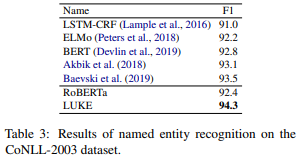

# <font color='brown' size=4>3. LUKE Training</font>

In [ ]:
train_df = pd.read_csv('../input/feedback-prize-2021/train.csv')
train_df['discourse_start']=train_df['discourse_start'].apply(lambda x:int(x))
train_df['discourse_end']=train_df['discourse_end'].apply(lambda x:int(x))
train_df=train_df.groupby('id').agg({'discourse_start':list,'discourse_end':list,'discourse_type':list,'predictionstring':list})

train_df['spans']=train_df[['discourse_start','discourse_end']].apply(lambda x: list(zip(x[0],x[1])),axis=1)
train_df['spans']=train_df[['discourse_start','discourse_end']].apply(lambda x: list(zip(x[0],x[1])),axis=1)

## <font color='brown' size=4>3.1 Helpers</font>

In [ ]:
def create_chunks(
    uniqueid: int = 0,
    content: str = "",
    tokenizer: RobertaTokenizer = None,
    max_length: int = 512,
):
    """
    Chunk the given text

    :param uniqueid: Unique id for the record
    :param content: Text to chunk
    :param tokenizer: Tokenizer from huggingface library
    :param max_length: Max length the chunked sentence has to be, after tokenizing
    :return: Returns a list of chunked sentences.
    """

    try:
        all_chunks = []
        splits = tokenizer.encode_plus(
            content,
            add_special_tokens=False,
            return_tensors="pt",
            return_offsets_mapping=True,
        )
        offsets = splits["offset_mapping"][0].split(max_length)

        if len(offsets) > 1:
            for ix, offset in enumerate(offsets):

                if ix == 0:
                    all_chunks.append(
                        (uniqueid, 0, content[0 : offset[-1][1]])
                    )
                else:
                    all_chunks.append(
                        (
                            uniqueid,
                            int(offset[0][0]),
                            content[offset[0][0] : offset[-1][1]],
                        )
                    )

        else:
            all_chunks.append((uniqueid, 0, content[0 : offsets[0][-1][1]]))

        return all_chunks

    except Exception as e:
        print(f"Chunking failed : {str(e)}")
        print(f"Chunk text: {content}")
        return [(-100, 0, "")]

> **📌 Note**:The above function can be used to break down the longer text into chunks. It is not used as part of training process. We can use it in inference pipeline

In [ ]:
def correct_spans(offsets):
    new_offsets=[]
    for ix,span in enumerate(offsets):
        
        if ix==0:
            new_offsets.append(span)
        elif offsets[ix-1][1]==offsets[ix][0]:
            new_offsets.append((span[0]+1,span[1]))
        else:
            new_offsets.append(span)
            
    return new_offsets

def fill_spans(offsets,labels):
    new_offsets=[]
    new_labels=[]
    
    for ix,span in enumerate(offsets):
        
        if ix==0 and span[0]==0:
            new_offsets.append(span)
            new_labels.append(labels[ix])
            
        elif ix==0 and span[0]!=0:
            new_offsets.append((0,span[0]-1))
            new_labels.append('Nil')
            
            new_offsets.append(span)
            new_labels.append(labels[ix])
            
        elif offsets[ix][0]-offsets[ix-1][1]>1:
            new_offsets.append((offsets[ix-1][1]+1,offsets[ix][0]-1))
            new_offsets.append(span)
            
            new_labels.append('Nil')
            new_labels.append(labels[ix])
        else:
            new_offsets.append(span)
            new_labels.append(labels[ix])
            
    return (new_offsets,new_labels)


def fix_chars(text,span):
    span[-1]=(span[-1][0],len(text.strip()))
        
    return span

> **📌 Note**: Brief overview of the above helper functions
- correct_spans - fixes spans which are continuous 
    - eg: [(3,4),(4,5)] -> [(3,4),(5,6)]
- fill_spans - fills the inbetween spans and also labels them as nil entity 
    - eg: [(5,8),(11,12)] ['claim','claim'] - > [(0,4),(5,8),(9,10),(11,12)] ['Nil','claim','Nil','claim']

In [ ]:
train_df['spans']=train_df['spans'].apply(lambda x:correct_spans(x))
train_df[['spans','discourse_type']]=train_df[['spans','discourse_type']].apply(lambda x:fill_spans(x[0],x[1]),axis=1,result_type='expand')
train_df['spans']=train_df['spans'].apply(lambda x:correct_spans(x))

In [ ]:
######### Unit test to make sure the spans are correct
for i in range(len(train_df)):
    assert len(train_df.iloc[i]['spans'])==len(train_df.iloc[i]['discourse_type'])
    
for i in range(len(train_df)):

    spans=train_df.iloc[i]['spans']
    for ix, span in enumerate(spans):
        if ix==0:
            pass
        else:
            assert (spans[ix][0]-spans[ix-1][1])==1

In [ ]:
# https://www.kaggle.com/raghavendrakotala/fine-tunned-on-roberta-base-as-ner-problem-0-533
test_names, train_texts = [], []
for f in tqdm(list(os.listdir('../input/feedback-prize-2021/train'))):
    test_names.append(f.replace('.txt', ''))
    train_texts.append(open('../input/feedback-prize-2021/train/' + f, 'r').read())
train_text_df = pd.DataFrame({'id': test_names, 'text': train_texts})
train_text_df.head()

In [ ]:
train_df=train_text_df.merge(train_df,on='id')

train_df['tok_len']=train_df['text'].apply(lambda x: len(spans_tokenizer.tokenize(x)))
train_df=train_df[train_df['tok_len']<450].head(500)
train_df.head()

<p>We run only on limited set of examples for demo and also on records which are less than 512 token length</p>

In [ ]:
train_df['spans']=train_df[['text','spans']].apply(lambda x:fix_chars(x[0],x[1]),axis=1)
train_df['text']=train_df['text'].apply(lambda x:x.strip())

In [ ]:
# CREATE DICTIONARIES THAT WE CAN USE DURING TRAIN AND INFER
output_labels = ['Nil', 'Lead', 'Position','Claim', 'Counterclaim','Rebuttal', 'Evidence', 'Concluding Statement']

labels_to_ids = {v:k for k,v in enumerate(output_labels)}
ids_to_labels = {k:v for k,v in enumerate(output_labels)}

In [ ]:
train_df['discourse_type']=train_df['discourse_type'].apply(lambda x: [labels_to_ids[label] for label in x])

In [ ]:
train_df[:2]

## <font color='brown' size=4>3.2 Dataset</font>

In [ ]:
class luke_dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
    
        # GET TEXT AND WORD LABELS 
        text = self.data.text[index]  
        spans = self.data.spans[index]
        
        print("1111",spans)
        # TOKENIZE TEXT
        inputs = self.tokenizer(text, entity_spans=spans)
        
        inputs = {key: torch.as_tensor(val) for key, val in inputs.items()}
        inputs['labels'] = torch.as_tensor(spans)
        
        return inputs

  def __len__(self):
        return self.len

In [ ]:
# CHOOSE VALIDATION INDEXES (that match my TF notebook)
IDS = train_df.id.unique()
print('There are',len(IDS),'train texts. We will split 90% 10% for validation.')

# TRAIN VALID SPLIT 90% 10%
np.random.seed(42)
train_idx = np.random.choice(np.arange(len(IDS)),int(0.9*len(IDS)),replace=False)
valid_idx = np.setdiff1d(np.arange(len(IDS)),train_idx)
np.random.seed(None)

In [ ]:
# CREATE TRAIN SUBSET AND VALID SUBSET
data = train_df[['id','text', 'spans','discourse_type']]
train_dataset = data.loc[data['id'].isin(IDS[train_idx])].reset_index(drop=True)
test_dataset = data.loc[data['id'].isin(IDS[valid_idx])].reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = luke_dataset(train_dataset, tokenizer, config['max_length'])
testing_set = luke_dataset(test_dataset, tokenizer,config['max_length'])

In [ ]:
# TRAIN DATASET AND VALID DATASET
train_params = {'batch_size': config['train_batch_size'],
                'shuffle': False,
                'num_workers': 2,
                'pin_memory':True
                }

test_params = {'batch_size': config['valid_batch_size'],
                'shuffle': False,
                'num_workers': 2,
                'pin_memory':True
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## <font color='brown' size=4>3.3 Engine</font>

In [ ]:
# https://www.kaggle.com/raghavendrakotala/fine-tunned-on-roberta-base-as-ner-problem-0-533
def train(df,epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    batch_size=config['train_batch_size']
    pad_token=-100
    
    # put model in training mode
    model.train()
    
    for batch_start_idx in range(0, len(df), batch_size):
        
        batch_examples = df.iloc[batch_start_idx:batch_start_idx + batch_size]
        
        # GET TEXT AND WORD LABELS 
        text = batch_examples['text'].values.tolist()  
        spans = batch_examples['spans'].values.tolist() 

        labels=batch_examples['discourse_type'].values.tolist() 
        labels = zip(*itertools.zip_longest(*labels, fillvalue=pad_token))
        
        # TOKENIZE TEXT
        inputs = tokenizer(text, entity_spans=spans,padding=True)
        inputs = {key: torch.as_tensor(val).cuda() for key, val in inputs.items()}

        inputs['labels']=torch.as_tensor(list(labels)).cuda()
        
        output=model(**inputs,return_dict=False)
    
        loss=output[0]
        logits=output[1]
        
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += inputs['labels'].size(0)
        
        if batch_start_idx % 200==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss after {batch_start_idx:4d} training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = inputs['labels'].view(-1) # shape (batch_size * seq_len,)
        active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = inputs['labels'].view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        #tr_labels.extend(labels)
        #tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=config['max_grad_norm']
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# CREATE MODEL
model = LukeForEntitySpanClassification.from_pretrained(config['model_name'])

In [ ]:
model.classifier=nn.Linear(3072,len(labels_to_ids))
model.num_labels=len(labels_to_ids)
model.config.id2label=ids_to_labels
model.config.label2id=labels_to_ids

In [ ]:
model.to(config['device'])
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['learning_rates'][0])

In [ ]:
# LOOP TO TRAIN MODEL
for epoch in range(config['epochs']):

    print(f"### Training epoch: {epoch + 1}")
    for g in optimizer.param_groups: 
        g['lr'] = config['learning_rates'][epoch]
    lr = optimizer.param_groups[0]['lr']
    print(f'### LR = {lr}\n')

    train(train_df,epoch)
    torch.cuda.empty_cache()
    gc.collect()

torch.save(model.state_dict(), 'luke.pt')

# <font color='brown' size=4>4. HF trainer for NER</font>

In [ ]:
train_df = pd.read_csv('../input/train-ner/train_NER.csv',nrows=1000)

train_df['tokens']=train_df['text'].apply(lambda x: x.split())
train_df['entities']=train_df['entities'].apply(lambda x: eval(x))

In [ ]:
train_df.head(2)

In [ ]:
# CHOOSE VALIDATION INDEXES (that match my TF notebook)
IDS = train_df.id.unique()
print('There are',len(IDS),'train texts. We will split 90% 10% for validation.')

# TRAIN VALID SPLIT 90% 10%
np.random.seed(42)
train_idx = np.random.choice(np.arange(len(IDS)),int(0.9*len(IDS)),replace=False)
valid_idx = np.setdiff1d(np.arange(len(IDS)),train_idx)
np.random.seed(None)

In [ ]:
# CREATE TRAIN SUBSET AND VALID SUBSET
data = train_df[['id','tokens', 'entities']]
train_dataset = data.loc[data['id'].isin(IDS[train_idx]),['tokens', 'entities']].reset_index(drop=True)
val_dataset = data.loc[data['id'].isin(IDS[valid_idx])].reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(val_dataset.shape))


In [ ]:
label_all_tokens=True

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], padding=True, truncation=True, 
                                 is_split_into_words=True, return_offsets_mapping=True)

    labels = []
    for i, label in enumerate(examples["entities"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label with I-tag or -100, depending on
            # the label_all_tokens flag.
            else:
                if label_all_tokens:
                    new_label = id2tag[label[word_idx]].replace('B-', 'I-')
                    label_ids.append(tag2id[new_label])
                else:
                    label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
# mappings
all_tags = ['O', 'B-Lead', 'I-Lead', 'B-Position', 'I-Position', 'B-Claim', 'I-Claim', 'B-Counterclaim', 'I-Counterclaim', 
          'B-Rebuttal', 'I-Rebuttal', 'B-Evidence', 'I-Evidence', 'B-Concluding Statement', 'I-Concluding Statement']
unique_tags = sorted(set(all_tags))
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [ ]:
# encode labels
train_dataset['entities'] = train_dataset['entities'].apply(lambda labels: [tag2id[x] for x in labels])
val_dataset['entities'] = val_dataset['entities'].apply(lambda labels: [tag2id[x] for x in labels])

In [ ]:
train_dataset = ds.from_pandas(train_dataset[['tokens', 'entities']])
val_dataset = ds.from_pandas(val_dataset[['tokens', 'entities']])

In [ ]:
datasets = DatasetDict({
    'train': train_dataset,
    'val': val_dataset
})

datasets

In [ ]:
label_list = list(unique_tags)
print(sorted(label_list))

In [ ]:
class config:
    batch_size=4
    model_checkpoint = 'roberta-base'
    num_classes=len(label_list)
    label_all_tokens = True
    lr_rate=3.3374982585607736e-05
    epochs=5
    weight_decay=0.013998996632720116
    device='cuda' if cuda.is_available() else 'cpu'
    
config=config()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.model_checkpoint, add_prefix_space=True, do_lower_case=False)
model = AutoModelForTokenClassification.from_pretrained(config.model_checkpoint, num_labels=len(label_list)).to(config.device)

In [ ]:
model.num_labels = config.num_classes
model.config.num_labels = config.num_classes
model.config.id2label=id2tag
model.config.label2id=tag2id

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
# align labels with subword tokens
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)
tokenized_datasets

In [ ]:
metric = load_metric("seqeval")

In [ ]:
if '/' in config.model_checkpoint:
    model_name = config.model_checkpoint.split("/")[-1]
else:
    model_name = config.model_checkpoint

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-ner",
    logging_dir = f"{model_name}-finetuned-ner/runs",
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    save_strategy='epoch',
    logging_strategy='epoch',
#     save_steps=100,
#     eval_steps=100,
#     logging_steps=100,
    #log_level='info',
    learning_rate=config.lr_rate,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    num_train_epochs=config.epochs,
    weight_decay=config.weight_decay,
    push_to_hub=False,
    load_best_model_at_end=True,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
#trainer.train()

Uncomment the above line for training

# <font color='brown' size=4>5. Acknowledgements</font>

1. https://arxiv.org/pdf/2010.01057.pdf
2. https://huggingface.co/docs/transformers/model_doc/luke
3. https://www.kaggle.com/cdeotte/pytorch-bigbird-ner-cv-0-615